In [ ]:
import kagglehub

# Download to 'kaggle' folder
path = kagglehub.dataset_download("sanikatiwarekar/deep-fake-detection-dfd-entire-original-dataset")

print("Dataset downloaded to:", path)

import os
import shutil

CURRENT_DIR = os.path.join(os.getcwd(), 'DFD')  # Moves to 'kaggle' folder in the current working directory

for item in os.listdir(path):
    source = os.path.join(path, item)
    destination = os.path.join(CURRENT_DIR, item)

    if os.path.isdir(source):
        shutil.move(source, destination)
    else:
        shutil.move(source, destination)

print(f"All files and folders moved from {path} to {CURRENT_DIR}")

# Installing the relevant package for this EDA process

In [1]:
# %pip install cv2
# %pip install ffmpeg-python opencv-python pandas tqdm
# %pip install scikit-image seaborn
# %pip install --upgrade numpy
# %pip install --upgrade scipy
# %pip install --upgrade pandas
# %pip install --upgrade matplotlib
# %pip install --user mediapipe pandas
# %pip install numpy<2
# %pip list
# %pip install dlib --no-cache-dir

# %pip install -r requirements.txt
# %pip install cmake --force-reinstall
# %pip install cmake
# %python.exe -m pip install --upgrade pip
%pip list


Package                   Version
------------------------- ------------
absl-py                   2.1.0
ace_tools                 0.0
aiofiles                  22.1.0
aiosqlite                 0.18.0
anyio                     3.5.0
appnope                   0.1.4
apyori                    1.1.2
argon2-cffi               21.3.0
argon2-cffi-bindings      21.2.0
asttokens                 3.0.0
attrs                     23.1.0
audioread                 3.0.1
Babel                     2.11.0
backcall                  0.2.0
beautifulsoup4            4.12.2
bleach                    4.1.0
boltons                   23.0.0
Bottleneck                1.3.5
Brotli                    1.0.9
certifi                   2025.1.31
cffi                      1.17.1
charset-normalizer        3.4.1
click                     8.1.8
colorama                  0.4.6
comm                      0.2.2
conda                     23.7.3
conda-package-handling    2.2.0
conda_package_streaming   0.9.0
contourpy          

In [2]:
import subprocess
subprocess.run(["cmake", "--version"])


CompletedProcess(args=['cmake', '--version'], returncode=0)

# Video Dataset Analysis

This notebook contains scripts to analyze and compare real and fake (manipulated) videos. The main objectives are:

1. **Dataset Overview**: Summarize the number of videos, file extensions, and sample files for both real and fake videos.
2. **Video Metadata Extraction**: Extract metadata such as resolution, duration, frame rate, and file size for each video.
3. **Matching Real and Fake Videos**: Identify and match real videos to their corresponding fake versions.

## Summary of Real and Fake Videos

- **Real Videos**: 358 videos
- **Fake Videos**: 3068 videos

## Sample Files

### Real Videos
- 01__exit_phone_room.mp4
- 01__hugging_happy.mp4

In [3]:
import os 
import re
import cv2
import pandas as pd
from collections import Counter
from IPython.display import display
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import numpy as np
import concurrent.futures

import mediapipe as mp


c:\Users\juayk\anaconda3\envs\is217_env\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [4]:
real_videos_path = "../archive/real"
fake_videos_path = "../archive/fake"

def get_file_info(folder_path, label):
    files = os.listdir(folder_path)
    file_extensions = [os.path.splitext(f)[-1].lower() for f in files]
    
    return {
        'label': label,
        'num_videos': len(files),
        'extensions_count': dict(Counter(file_extensions)),
        'sample_files': files[:5]  # Display first 5 files
    }

# Get dataset summary for real and fake videos
real_summary = get_file_info(real_videos_path, "Real")
fake_summary = get_file_info(fake_videos_path, "Fake")

# Create a DataFrame for better visualization
df_summary = pd.DataFrame([real_summary, fake_summary])

# Display dataset overview
display(df_summary)

,label,num_videos,extensions_count,sample_files
0,Real,358,{'.mp4': 358},"[01__exit_phone_room.mp4, 01__hugging_happy.mp..."
1,Fake,3068,{'.mp4': 3068},"[01_02__exit_phone_room__YVGY8LOK.mp4, 01_02__..."


In [5]:
def get_video_files(directory):
    """Get list of video files in a directory."""
    return [f for f in os.listdir(directory) 
            if f.lower().endswith(('.mp4', '.avi', '.mov'))]

def extract_base_name(filename, is_fake=False):
    """
    Extract base name from filename.
    Real video format: '01__exit_phone_room.mp4'
    Fake video format: '01_09__exit_phone_room__6TSGVLHA.mp4'
    Returns: '01__exit_phone_room'
    """
    # Remove file extension
    base = os.path.splitext(filename)[0]
    
    if is_fake:
        # For fake videos, extract the first number and the action part
        # Pattern: extract everything between the second underscore pair
        match = re.match(r'\d+_\d+__(.+?)__[A-Z0-9]+$', base)
        if match:
            action = match.group(1)
            # Get the first number
            first_num = base.split('_')[0]
            return f"{first_num}__{action}"
    else:
        # For real videos, just return as is (it's already in the format we want)
        return base

def compare_datasets(fake_dir='../archive/fake', real_dir='../archive/real'):
    # Get video lists
    fake_videos = get_video_files(fake_dir)
    real_videos = get_video_files(real_dir)
    
    print(f"\nTotal videos found:")
    print(f"- Fake videos: {len(fake_videos)}")
    print(f"- Real videos: {len(real_videos)}")
    
    # Create dictionaries with base names as keys
    fake_dict = {extract_base_name(f, is_fake=True): f for f in fake_videos}
    real_dict = {extract_base_name(f, is_fake=False): f for f in real_videos}
    
    # Print some examples of the name matching
    print("\nExample name matching:")
    for fake_file in fake_videos[:3]:  # Show first 3 examples
        fake_base = extract_base_name(fake_file, is_fake=True)
        print(f"Fake file: {fake_file}")
        print(f"Extracted base: {fake_base}")
        print("---")
    
    # Find real videos without corresponding fake versions
    missing_fakes = []
    for real_base, real_file in real_dict.items():
        if real_base not in fake_dict:
            missing_fakes.append((real_file, real_base))
    
    # Find fake videos without corresponding real versions
    extra_fakes = []
    for fake_base, fake_file in fake_dict.items():
        if fake_base not in real_dict:
            extra_fakes.append((fake_file, fake_base))
    
    # Find matching pairs
    matching_pairs = []
    for base in set(real_dict.keys()) & set(fake_dict.keys()):
        matching_pairs.append((real_dict[base], fake_dict[base]))
    
    # Print results
    print("\nAnalysis Results:")
    print(f"Found {len(matching_pairs)} matching pairs")
    
    if missing_fakes:
        print(f"\nWARNING: {len(missing_fakes)} real videos don't have corresponding fake versions:")
        for video, base in missing_fakes:
            print(f"- {video}")
            print(f"  Base name: {base}")
    
    if extra_fakes:
        print(f"\nINFO: {len(extra_fakes)} fake videos don't have corresponding real versions:")
        for video, base in extra_fakes:
            print(f"- {video}")
            print(f"  Base name: {base}")
    
    print("\nMatching pairs:")
    for real, fake in matching_pairs:
        print(f"Real: {real:<40} <-> Fake: {fake}")
    
    return matching_pairs, missing_fakes, extra_fakes

if __name__ == '__main__':
    compare_datasets() 


Total videos found:
- Fake videos: 3068
- Real videos: 358

Example name matching:
Fake file: 01_02__exit_phone_room__YVGY8LOK.mp4
Extracted base: 01__exit_phone_room
---
Fake file: 01_02__hugging_happy__YVGY8LOK.mp4
Extracted base: 01__hugging_happy
---
Fake file: 01_02__meeting_serious__YVGY8LOK.mp4
Extracted base: 01__meeting_serious
---

Analysis Results:
Found 358 matching pairs

Matching pairs:
Real: 14__secret_conversation.mp4              <-> Fake: 14_26__secret_conversation__SU8SAHTT.mp4
Real: 02__meeting_serious.mp4                  <-> Fake: 02_27__meeting_serious__QW05XUUZ.mp4
Real: 15__outside_talking_pan_laughing.mp4     <-> Fake: 15_25__outside_talking_pan_laughing__BXVA6VQB.mp4
Real: 22__walking_down_street_outside_angry.mp4 <-> Fake: 22_24__walking_down_street_outside_angry__XL557XC6.mp4
Real: 06__walking_down_street_outside_angry.mp4 <-> Fake: 06_27__walking_down_street_outside_angry__S3T7SK9O.mp4
Real: 11__kitchen_pan.mp4                      <-> Fake: 11_26__kitche

In [6]:
# Function to get video metadata
def get_video_metadata(video_path):
    try:
        # Using ffmpeg to extract metadata
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            return None
        
        # Extract metadata
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        duration = frame_count / fps if fps > 0 else 0
        file_size = os.path.getsize(video_path) / (1024 * 1024)  # Convert bytes to MB
        
        cap.release()

        return {
            'filename': os.path.basename(video_path),
            'width': width,
            'height': height,
            'duration_SEC': round(duration, 2),
            'frame_rate': round(fps, 2),
            'file_size_MB': round(file_size, 2)
        }
    except Exception as e:
        print(f"Error processing {video_path}: {e}")
    return None

# Extract metadata for all videos in a folder
def extract_video_properties(folder_path, label):
    video_data = []
    for video_file in tqdm(os.listdir(folder_path), desc=f"Processing {label} videos"):
        video_path = os.path.join(folder_path, video_file)
        metadata = get_video_metadata(video_path)
        if metadata:
            metadata['label'] = label
            video_data.append(metadata)
    return video_data

# Process both real and fake videos
real_video_data = extract_video_properties(real_videos_path, "Real")
fake_video_data = extract_video_properties(fake_videos_path, "Fake")

# Convert to DataFrame
df_real = pd.DataFrame(real_video_data)
df_fake = pd.DataFrame(fake_video_data)
df_videos = pd.concat([df_real, df_fake], ignore_index=True)

# Display dataframe
display(df_videos)

Processing Real videos:   0%|          | 0/358 [00:00<?, ?it/s]

Processing Fake videos: 100%|██████████| 3068/3068 [01:07<00:00, 45.77it/s]


,filename,width,height,duration_SEC,frame_rate,file_size_MB,label
0,01__exit_phone_room.mp4,1920,1080,12.71,24.0,1.80,Real
1,01__hugging_happy.mp4,1920,1080,32.79,24.0,10.83,Real
2,01__kitchen_pan.mp4,1920,1080,23.33,24.0,4.13,Real
3,01__kitchen_still.mp4,1920,1080,33.33,24.0,5.55,Real
4,01__meeting_serious.mp4,1920,1080,43.54,24.0,6.27,Real
...,...,...,...,...,...,...,...
3421,28_16__walking_down_street_outside_angry__6DWL...,1920,1080,49.92,24.0,5.06,Fake
3422,28_16__walking_down_street_outside_angry__U757...,1920,1080,48.21,24.0,4.73,Fake
3423,28_16__walking_down_street_outside_angry__ZA8X...,1920,1080,49.17,24.0,5.02,Fake
3424,28_16__walking_outside_cafe_disgusted__NAZP864...,1920,1080,15.54,24.0,2.51,Fake


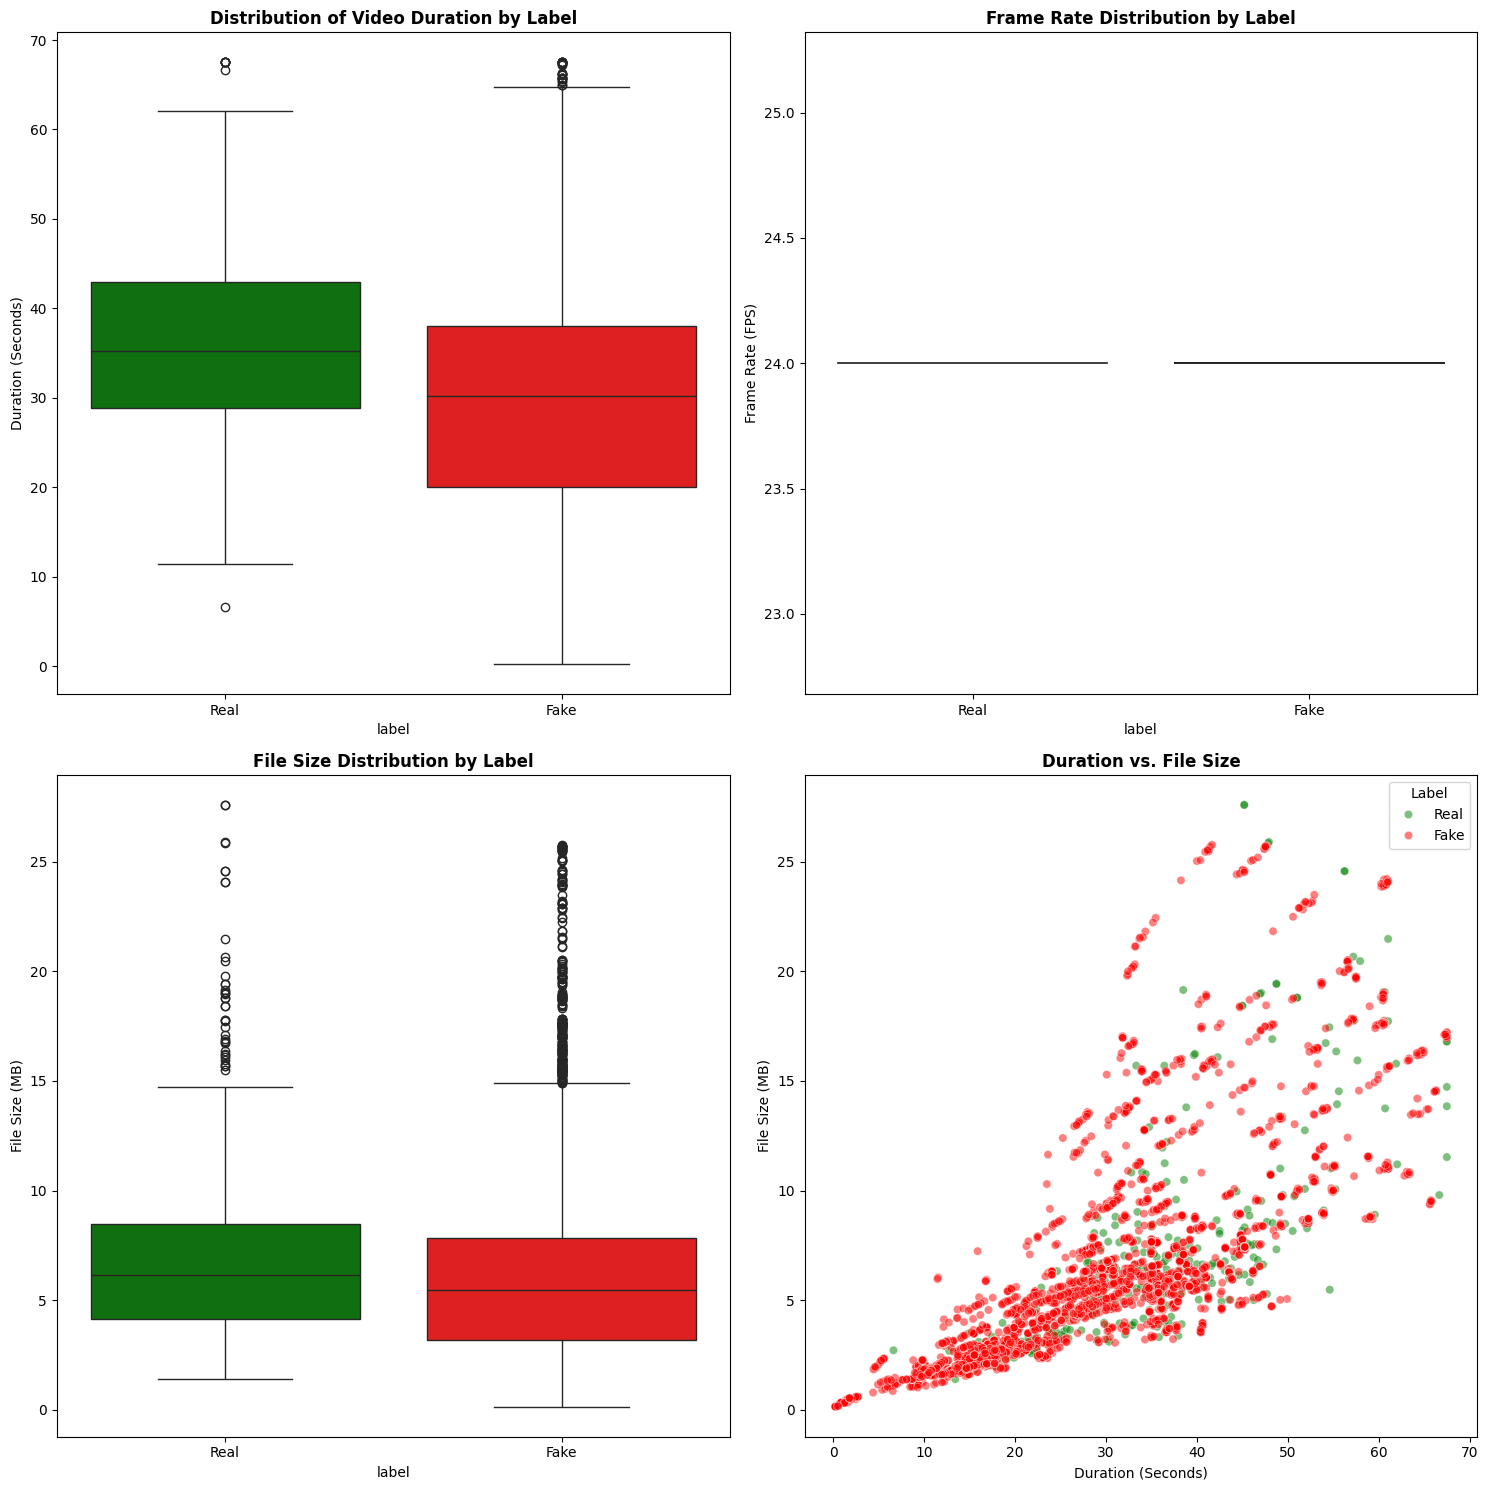

In [7]:
#to display metdata breakdown
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# Define the color palette
palette = {"Real": "green", "Fake": "red"}

# 1. Distribution of Video Durations
sns.boxplot(y="duration_SEC", x="label", hue="label", data=df_videos, ax=axes[0, 0], palette=palette)
axes[0, 0].set_title("Distribution of Video Duration by Label", fontweight='bold')
axes[0, 0].set_ylabel("Duration (Seconds)")

# 2. Frame Rate Distribution
sns.violinplot(x="label", y="frame_rate", hue="label", data=df_videos, palette=palette, ax=axes[0, 1], inner="quartile")
axes[0, 1].set_title("Frame Rate Distribution by Label", fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel("Frame Rate (FPS)", fontsize=10)

# 3. File Size Comparison
sns.boxplot(y="file_size_MB", x="label", hue="label", data=df_videos, ax=axes[1, 0], palette=palette)
axes[1, 0].set_title("File Size Distribution by Label", fontweight='bold')
axes[1, 0].set_ylabel("File Size (MB)")

# 4. Scatter Plot: Duration vs. File Size
sns.scatterplot(x="duration_SEC", y="file_size_MB", alpha=0.5, hue="label", data=df_videos, palette=palette, ax=axes[1, 1])
axes[1, 1].set_title("Duration vs. File Size", fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel("Duration (Seconds)", fontsize=10)
axes[1, 1].set_ylabel("File Size (MB)", fontsize=10)
axes[1, 1].legend(title="Label")

plt.tight_layout()
plt.show()

In [ ]:
frame_output_path = "extracted_frames_fake_video"

# Ensure output folder exists
os.makedirs(frame_output_path, exist_ok=True)

# Function to check if a video has already been processed
def are_frames_extracted(video_name, label):
    """Check if frames for a given video already exist."""
    for file in os.listdir(frame_output_path):
        if file.startswith(f"{label}_{video_name}_frame"):
            return True  # Frame already exists, skip processing
    return False  # No frames found, process video

# Function to extract frames at intervals
def extract_frames(video_path, label, interval=120):  # Extract every N frames
    cap = cv2.VideoCapture(video_path)
    frame_list = []
    frame_index = 0
    video_name = os.path.basename(video_path).split('.')[0]

     # Check if frames exist, but DO NOT SKIP the analysis
    frames_already_extracted = are_frames_extracted(video_name, label)

    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break
        if frame_index % interval == 0:  # Capture every 'interval' frame
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
            frame_list.append(frame_gray)

            # Save frame ONLY if they are not already extracted
            if not frames_already_extracted:
                frame_filename = f"{frame_output_path}/{label}_{video_name}_frame{frame_index}.jpg"
                cv2.imwrite(frame_filename, frame)
        
        frame_index += 1

    cap.release()
    return frame_list

# Compute histogram and SSIM between consecutive frames
def analyze_frames(frames):
    histograms = []
    ssim_values = []

    for i in range(len(frames) - 1):
        # Compute pixel intensity histogram
        hist = cv2.calcHist([frames[i]], [0], None, [256], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        histograms.append(hist)

        # Compute SSIM (Structural Similarity Index) with next frame
        ssim_value = ssim(frames[i], frames[i + 1])
        ssim_values.append(ssim_value)

    return histograms, ssim_values

# Process a single video (this function will be threaded)
def process_video(video_file, folder_path, label):
    video_path = os.path.join(folder_path, video_file)
    video_name = os.path.basename(video_file).split('.')[0]

    # Check if frames are already extracted, if so, skip
    if is_video_processed(video_name, label):
        return None

    frames = extract_frames(video_path, label)
    histograms, ssim_values = analyze_frames(frames)

    # Return statistics for this video
    return {
        'filename': video_file,
        'label': label,
        'num_frames': len(frames),
        'avg_ssim': np.mean(ssim_values) if ssim_values else 0
    }

# Process videos
video_data = []

with concurrent.futures.ThreadPoolExecutor(max_workers=6) as executor:  # Adjust max_workers as needed
    future_to_video = {}

    for folder_path, label in [(real_videos_path, "Real"), (fake_videos_path, "Fake")]:
        for video_file in os.listdir(folder_path):
            future = executor.submit(process_video, video_file, folder_path, label)
            future_to_video[future] = video_file

    for future in tqdm(concurrent.futures.as_completed(future_to_video), total=len(future_to_video), desc="Processing Videos"):
        result = future.result()
        if result:
            video_data.append(result)

# Ensure video_data is not empty before creating DataFrame
if video_data:
    df_video_analysis = pd.DataFrame(video_data)
    df_video_analysis.to_csv("video_analysis_results.csv", index=False)
else:
    df_video_analysis = pd.DataFrame(columns=['filename', 'label', 'num_frames', 'avg_ssim'])

# Display results
display(df_video_analysis)

# Plot SSIM distributions
if not df_video_analysis.empty:
    plt.figure(figsize=(10, 5))
    plt.hist(df_video_analysis[df_video_analysis['label'] == 'Real']['avg_ssim'], bins=20, alpha=0.7, label='Real', color='blue')
    plt.hist(df_video_analysis[df_video_analysis['label'] == 'Fake']['avg_ssim'], bins=20, alpha=0.7, label='Fake', color='red')
    plt.xlabel("Average SSIM Between Frames")
    plt.ylabel("Frequency")
    plt.title("SSIM Distribution: Real vs Fake Videos")
    plt.legend()
    plt.show()
else:
    print("No video data to plot.")


Processing Videos: 100%|██████████| 3426/3426 [06:22<00:00,  8.95it/s]


,filename,label,num_frames,avg_ssim


No video data to plot.


Processing Fake Videos: 100%|██████████| 3068/3068 [4:37:11<00:00,  5.42s/it]  


                                               filename label  num_frames  \
0                  01_02__exit_phone_room__YVGY8LOK.mp4  Fake           2   
1                    01_02__hugging_happy__YVGY8LOK.mp4  Fake           5   
2     01_02__outside_talking_still_laughing__YVGY8LO...  Fake           7   
3                  01_02__meeting_serious__YVGY8LOK.mp4  Fake           9   
4              01_02__secret_conversation__YVGY8LOK.mp4  Fake           8   
...                                                 ...   ...         ...   
3063  28_16__walking_outside_cafe_disgusted__NAZP864...  Fake           4   
3064  28_16__walking_down_street_outside_angry__6DWL...  Fake          10   
3065  28_16__walking_down_street_outside_angry__U757...  Fake          10   
3066  28_16__walking_down_street_outside_angry__ZA8X...  Fake          10   
3067          28_16__walk_down_hall_angry__X5FNCYON.mp4  Fake           5   

      avg_ssim  
0     0.863182  
1     0.724555  
2     0.859058  
3     0

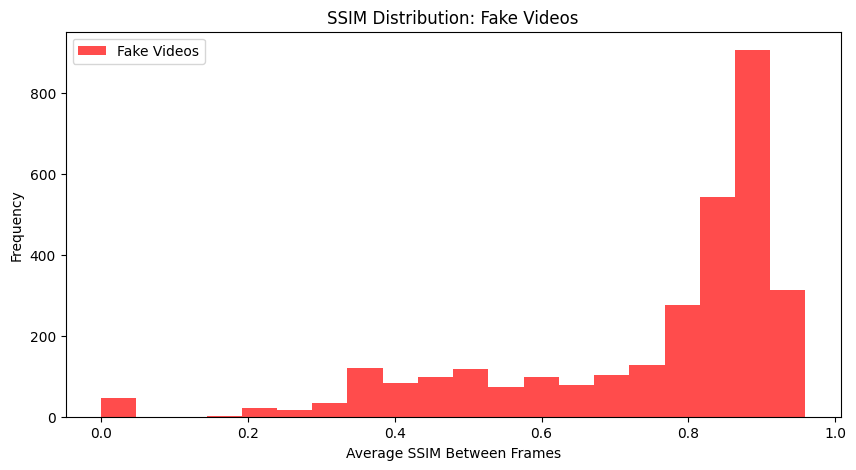

In [9]:
# Define paths
fake_videos_path = "../archive/fake"
frame_output_path = "extracted_frames_fake_video"

# Ensure output folder exists
os.makedirs(frame_output_path, exist_ok=True)

def are_frames_extracted(video_name):
    """Check if frames for a given video already exist."""
    for file in os.listdir(frame_output_path):
        if file.startswith(f"Fake_{video_name}_frame"):
            return True  # Skip processing if frames already exist
    return False  

def extract_frames(video_path, interval=120):
    cap = cv2.VideoCapture(video_path)
    frame_list = []
    frame_index = 0
    video_name = os.path.basename(video_path).split('.')[0]

    frames_already_extracted = are_frames_extracted(video_name)

    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break
        if frame_index % interval == 0:
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame_list.append(frame_gray)

            if not frames_already_extracted:
                frame_filename = os.path.join(frame_output_path, f"Fake_{video_name}_frame{frame_index}.jpg")
                cv2.imwrite(frame_filename, frame)

        frame_index += 1

    cap.release()
    return frame_list

def analyze_frames(frames):
    histograms = []
    ssim_values = []

    for i in range(len(frames) - 1):
        hist = cv2.calcHist([frames[i]], [0], None, [256], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        histograms.append(hist)

        ssim_value = ssim(frames[i], frames[i + 1])
        ssim_values.append(ssim_value)

    return histograms, ssim_values

def process_video(video_file):
    video_path = os.path.join(fake_videos_path, video_file)
    video_name = os.path.basename(video_file).split('.')[0]

    if are_frames_extracted(video_name):
        return None  # Skip if already processed

    frames = extract_frames(video_path)
    histograms, ssim_values = analyze_frames(frames)

    return {
        'filename': video_file,
        'label': 'Fake',
        'num_frames': len(frames),
        'avg_ssim': np.mean(ssim_values) if ssim_values else 0
    }

# Process only Fake videos
video_data = []

with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
    future_to_video = {executor.submit(process_video, video_file): video_file for video_file in os.listdir(fake_videos_path)}

    for future in tqdm(concurrent.futures.as_completed(future_to_video), total=len(future_to_video), desc="Processing Fake Videos"):
        result = future.result()
        if result:
            video_data.append(result)

if video_data:
    df_video_analysis = pd.DataFrame(video_data)
    df_video_analysis.to_csv("video_analysis_results_fake.csv", index=False)
else:
    df_video_analysis = pd.DataFrame(columns=['filename', 'label', 'num_frames', 'avg_ssim'])

# Display results
print(df_video_analysis)

# Plot SSIM distribution for Fake videos
if not df_video_analysis.empty:
    plt.figure(figsize=(10, 5))
    plt.hist(df_video_analysis['avg_ssim'], bins=20, alpha=0.7, color='red', label='Fake Videos')
    plt.xlabel("Average SSIM Between Frames")
    plt.ylabel("Frequency")
    plt.title("SSIM Distribution: Fake Videos")
    plt.legend()
    plt.show()
else:
    print("No video data to plot.")

## Compute SSIM across Frames & Standard Deviation
One issue with deepfake videos is that frame similarities are too high and stable. To detect this:

In [6]:
# Compute SSIM Standard Deviation per Video
df_video_analysis["ssim_std"] = df_video_analysis["avg_ssim"].rolling(window=5, min_periods=1).std()

# Display the updated DataFrame with SSIM standard deviation
display(df_video_analysis)

# Plot SSIM Standard Deviation Distribution
plt.figure(figsize=(10, 5))
plt.hist(df_video_analysis[df_video_analysis["label"] == "Real"]["ssim_std"], bins=30, alpha=0.7, label="Real", color="green")
plt.hist(df_video_analysis[df_video_analysis["label"] == "Fake"]["ssim_std"], bins=30, alpha=0.7, label="Fake", color="red")
plt.xlabel("SSIM Standard Deviation")
plt.ylabel("Frequency")
plt.title("SSIM Standard Deviation Distribution: Real vs Fake Videos")
plt.legend()
plt.show()

NameError: name 'df_video_analysis' is not defined

### Generate a Heatmap using SSIM to detect altered regions
Rather than analyzing full-frame SSIM, break the video into regions (e.g., face area) and visualize where the deepfake artifacts appear

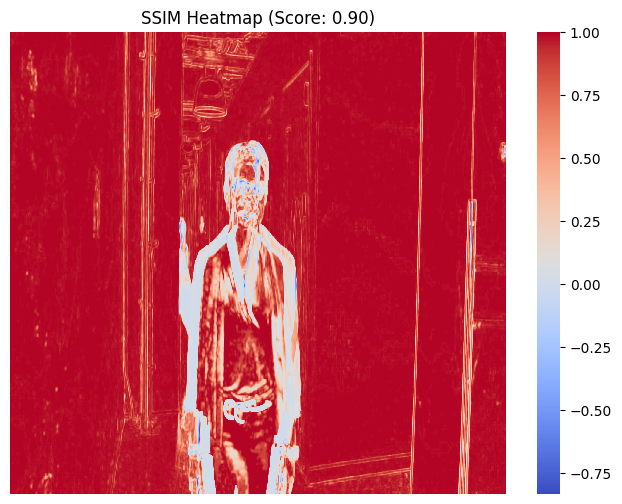

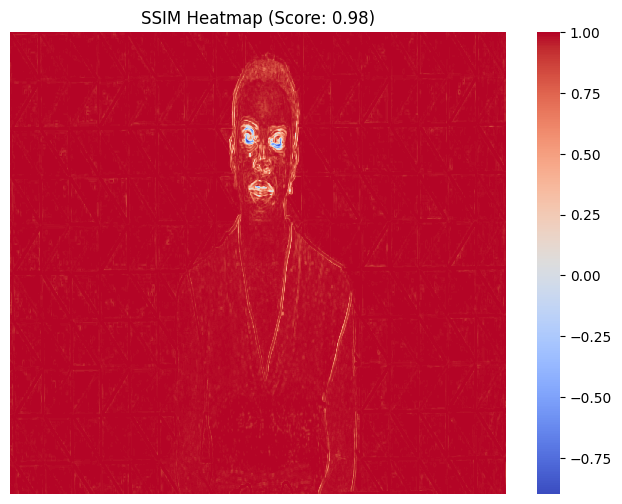

0.9833824762640517

In [7]:
def compute_ssim_heatmap(frame1, frame2):
    """Compute SSIM and generate a heatmap showing the differences."""
    if frame1 is None or frame2 is None:
        print("Error: One or both frames could not be loaded.")
        return None

    frame1_gray = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    frame2_gray = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

    # Compute SSIM Map
    ssim_score, ssim_map = ssim(frame1_gray, frame2_gray, full=True)
    
    # Display Heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(ssim_map, cmap="coolwarm", xticklabels=False, yticklabels=False)
    plt.title(f"SSIM Heatmap (Score: {ssim_score:.2f})")
    plt.show()

    return ssim_score

# Test on two consecutive frames from a sample fake video
frame1 = cv2.imread("extracted_frames/Fake_01_02__exit_phone_room__YVGY8LOK_frame90.jpg")
frame2 = cv2.imread("extracted_frames/Fake_01_02__exit_phone_room__YVGY8LOK_frame180.jpg")

frame3 = cv2.imread("extracted_frames/Real_01__talking_against_wall_frame270.jpg")
frame4 = cv2.imread("extracted_frames/Fake_01_02__talking_against_wall__YVGY8LOK_frame270.jpg")

compute_ssim_heatmap(frame1, frame2)
compute_ssim_heatmap(frame3, frame4)

### Comparing SSIM average of the Face and the background


Face SSIM: 0.7275, Background SSIM: 0.9635
SSIM Difference (Face - Background): 0.2360


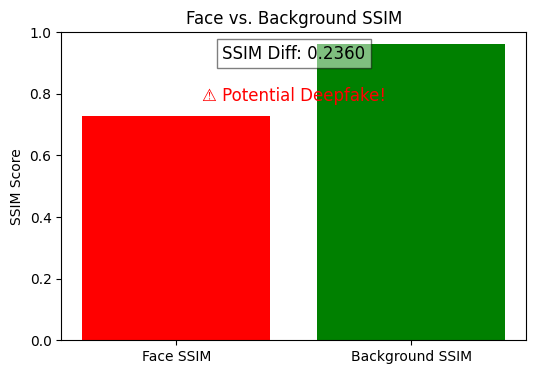

In [8]:
# Initialize MediaPipe Face Detection
mp_face_detection = mp.solutions.face_detection
face_detection = mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)


def extract_face_and_background(frame):
    """Detect face and create separate face and background images."""
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_detection.process(frame_rgb)

    h, w, _ = frame.shape
    face_mask = np.zeros((h, w), dtype=np.uint8)  # Mask for face
    face_region = None

    if results.detections:
        for detection in results.detections:
            bboxC = detection.location_data.relative_bounding_box
            x, y, w_box, h_box = (
                int(bboxC.xmin * w), int(bboxC.ymin * h),
                int(bboxC.width * w), int(bboxC.height * h)
            )

            # Ensure face region is within the frame bounds
            x, y = max(x, 0), max(y, 0)
            w_box, h_box = min(w_box, w - x), min(h_box, h - y)

            # Create face mask
            face_mask[y:y+h_box, x:x+w_box] = 255
            face_region = frame[y:y+h_box, x:x+w_box]
    
    # Ensure face_region has valid pixels
    if face_region is None or face_region.size == 0:
        return None, None

    # Background is everything outside the face
    background_region = cv2.bitwise_and(frame, frame, mask=cv2.bitwise_not(face_mask))

    return face_region, background_region

def compute_face_vs_background_ssim(video_path, interval=90):
    """Compare SSIM in face vs. background for each frame."""
    cap = cv2.VideoCapture(video_path)
    ret, prev_frame  = cap.read()
    prev_face, prev_bg = None, None
    face_ssim_scores = []
    bg_ssim_scores = []
    frame_index = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

         # Process only every 'interval' frame
        if frame_index % interval == 0:
            # Extract face and background regions
            face_region, background_region = extract_face_and_background(frame)

            if face_region is not None and prev_face is not None:
                # Convert to grayscale for SSIM calculation
                prev_face_gray = cv2.cvtColor(prev_face, cv2.COLOR_BGR2GRAY)
                face_gray = cv2.cvtColor(face_region, cv2.COLOR_BGR2GRAY)

                # Resize if shape mismatch occurs
                if prev_face_gray.shape != face_gray.shape:
                    face_gray = cv2.resize(face_gray, (prev_face_gray.shape[1], prev_face_gray.shape[0]))

                # Compute SSIM for face
                face_ssim = ssim(prev_face_gray, face_gray)

                face_ssim_scores.append(face_ssim)

            if background_region is not None and prev_bg is not None:
                prev_bg_gray = cv2.cvtColor(prev_bg, cv2.COLOR_BGR2GRAY)
                bg_gray = cv2.cvtColor(background_region, cv2.COLOR_BGR2GRAY)

                # Resize if needed
                if prev_bg_gray.shape != bg_gray.shape:
                    bg_gray = cv2.resize(bg_gray, (prev_bg_gray.shape[1], prev_bg_gray.shape[0]))

                # Compute SSIM for background
                bg_ssim = ssim(prev_bg_gray, bg_gray)
                bg_ssim_scores.append(bg_ssim)

            # Store previous frames
            prev_face = face_region
            prev_bg = background_region

        frame_index += 1  # Increment frame index

    cap.release()

    # Compute mean SSIM for face and background
    avg_face_ssim = np.mean(face_ssim_scores) if face_ssim_scores else 0
    avg_bg_ssim = np.mean(bg_ssim_scores) if bg_ssim_scores else 0

    return avg_face_ssim, avg_bg_ssim

# Run analysis on a sample video
video_path = "../archive/fake/01_02__talking_against_wall__YVGY8LOK.mp4"
face_ssim, bg_ssim = compute_face_vs_background_ssim(video_path)
print(f"Face SSIM: {face_ssim:.4f}, Background SSIM: {bg_ssim:.4f}")

# Display the difference
ssim_diff = bg_ssim - face_ssim
print(f"SSIM Difference (Face - Background): {ssim_diff:.4f}")

# Create bar chart for Face SSIM vs. Background SSIM
plt.figure(figsize=(6, 4))
bars = plt.bar(["Face SSIM", "Background SSIM"], [face_ssim, bg_ssim], color=["red", "green"])

# Add annotation for SSIM Difference
plt.text(0.5, max(face_ssim, bg_ssim) - 0.05, f"SSIM Diff: {ssim_diff:.4f}",
         fontsize=12, color="black", ha="center", bbox=dict(facecolor='white', alpha=0.5))

# Title & Labels
plt.title("Face vs. Background SSIM")
plt.ylabel("SSIM Score")
plt.ylim(0, 1)  # SSIM values are between 0-1

# Highlight if suspicious
if ssim_diff > 0.1:
    plt.text(0.5, min(face_ssim, bg_ssim) + 0.05, "⚠️ Potential Deepfake!", fontsize=12, color="red", ha="center")

plt.show()

### feature extraction (with a sample dataset)

🔹 Processing ../archive/sample_dataset\01_02__meeting_serious__YVGY8LOK.mp4 (1044 frames)
✅ Extracted 5 frames from ../archive/sample_dataset\01_02__meeting_serious__YVGY8LOK.mp4
🔹 Processing ../archive/sample_dataset\01_03__exit_phone_room__480LQD1C.mp4 (209 frames)
✅ Extracted 5 frames from ../archive/sample_dataset\01_03__exit_phone_room__480LQD1C.mp4
🔹 Processing ../archive/sample_dataset\01_03__hugging_happy__ISF9SP4G.mp4 (605 frames)
✅ Extracted 5 frames from ../archive/sample_dataset\01_03__hugging_happy__ISF9SP4G.mp4
🔹 Processing ../archive/sample_dataset\01_03__kitchen_still__JZUXXFRB.mp4 (529 frames)
✅ Extracted 5 frames from ../archive/sample_dataset\01_03__kitchen_still__JZUXXFRB.mp4
🔹 Processing ../archive/sample_dataset\01_04__exit_phone_room__0XUW13RW.mp4 (221 frames)
✅ Extracted 5 frames from ../archive/sample_dataset\01_04__exit_phone_room__0XUW13RW.mp4
🔹 Processing ../archive/sample_dataset\01_04__hugging_happy__GBC7ZGDP.mp4 (538 frames)
✅ Extracted 5 frames from ../a

C:\Users\juayk\AppData\Local\Temp\ipykernel_24656\2558785912.py:186: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Real", "Fake"], y=[df_real["saturation_variance"].mean(), df_fake["saturation_variance"].mean()],


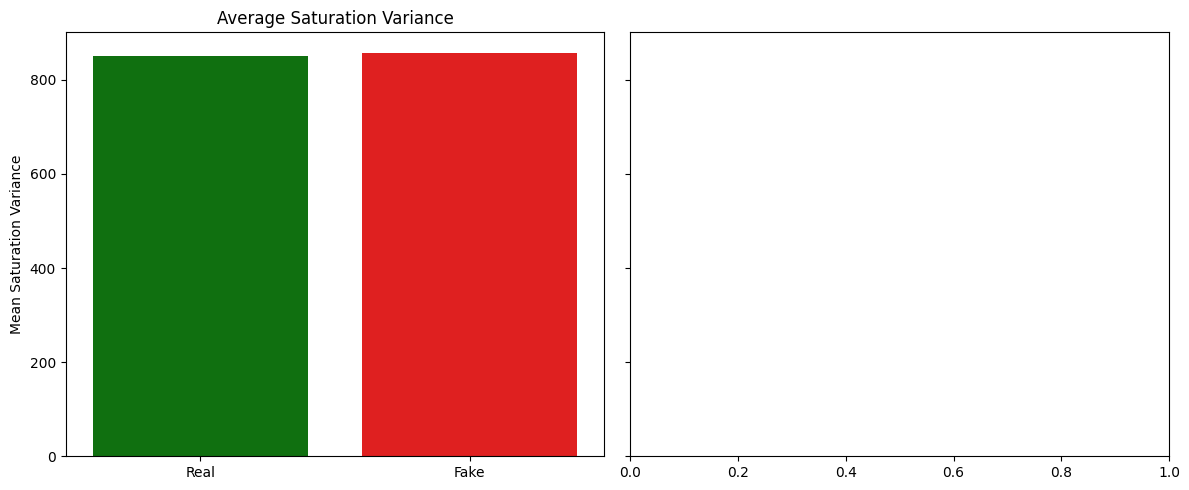

C:\Users\juayk\AppData\Local\Temp\ipykernel_24656\2558785912.py:197: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df_features["label"], y=df_features["lip_movement_variance"], palette=["green", "red"], ax=ax[1])


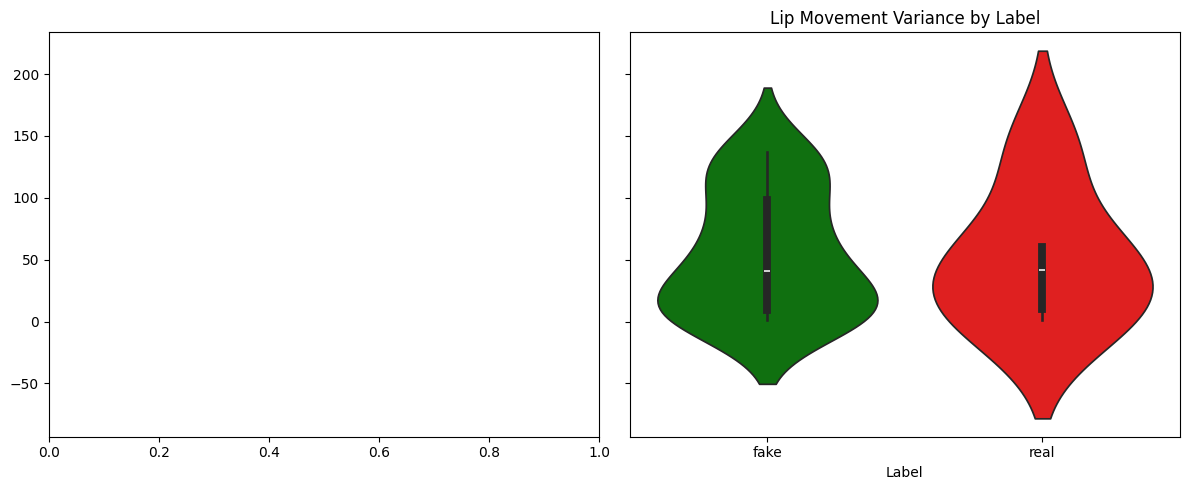

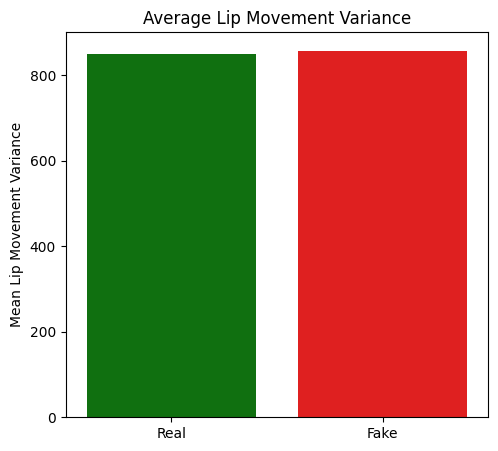

<Figure size 800x500 with 0 Axes>

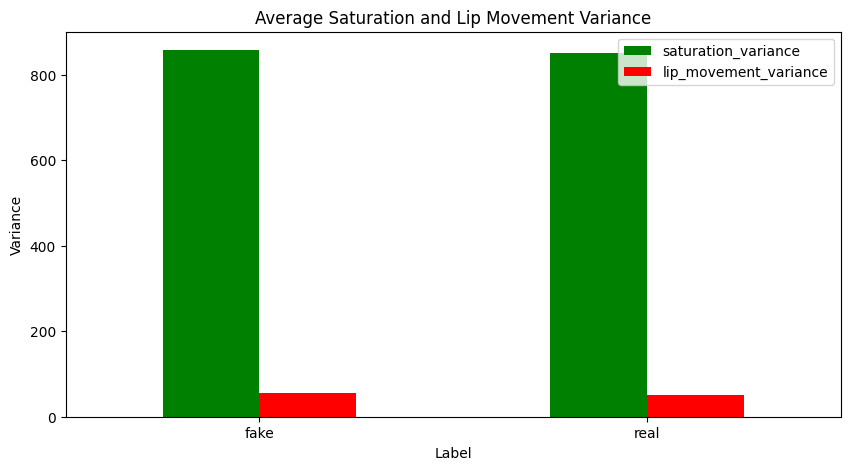

In [24]:
import dlib
from skimage.feature import local_binary_pattern

def extract_frames_from_video(video_path, num_frames=5):
    """
    Extracts num_frames evenly spaced frames from a video.
    Returns a list of frames.
    """
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"❌ Error: Cannot open video {video_path}")
        return []
    

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"🔹 Processing {video_path} ({total_frames} frames)")

    if total_frames < num_frames:
        print(f"Skipping {video_path}: Not enough frames ({total_frames} total)")
        cap.release()
        return []

    num_frames = min(num_frames, total_frames)
    frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
    frames = []

    for index in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, index)
        ret, frame = cap.read()
        if ret:
            frames.append(frame)

    cap.release()
    print(f"✅ Extracted {len(frames)} frames from {video_path}")
    return frames

# Initialize dlib's face detector (HOG-based) and create the facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

def compute_texture_variance(frames):
    """
    Computes texture variance using Local Binary Patterns (LBP) from extracted frames.
    Returns the average texture variance.
    """
    texture_variances = []

    for frame in frames:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Detect face
        faces = detector(gray)
        if len(faces) == 0:
            continue  # Skip frames where no face is detected

        for face in faces:
            landmarks = predictor(gray, face)

            # Extract key facial regions
            regions = [
                (min(max(landmarks.part(2).x, 0), w - 1), min(max(landmarks.part(2).y, 0), h - 1)),  # Left cheek
                (min(max(landmarks.part(14).x, 0), w - 1), min(max(landmarks.part(14).y, 0), h - 1)),  # Right cheek
                (min(max(landmarks.part(27).x, 0), w - 1), min(max(landmarks.part(27).y, 0), h - 1))   # Forehead
            ]

            # Compute LBP texture variance
            lbp = local_binary_pattern(gray, P=24, R=3, method="uniform")
            texture_values = [lbp[y, x] for x, y in regions]
            texture_variance = np.var(texture_values)
            texture_variances.append(texture_variance)

    return np.mean(texture_variances)

def compute_saturation_variance(frames):
    """Computes saturation variance from HSV color space in extracted frames."""
    saturation_variances = []

    for frame in frames:
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = detector(gray)

        if len(faces) == 0:
            continue

        for face in faces:
            landmarks = predictor(gray, face)
            regions = [
                (landmarks.part(2).x, landmarks.part(2).y),  # Left cheek
                (landmarks.part(14).x, landmarks.part(14).y),  # Right cheek
                (landmarks.part(27).x, landmarks.part(27).y)  # Forehead
            ]

            # Ensure points are within bounds
            h, w = hsv.shape[:2]
            regions = [(min(max(x, 0), w - 1), min(max(y, 0), h - 1)) for x, y in regions]

            saturation_values = [hsv[y, x, 1] for x, y in regions]
            saturation_variance = np.var(saturation_values)
            saturation_variances.append(saturation_variance)

    return np.mean(saturation_variances) if saturation_variances else None

def get_lip_movement(video_path, frame_skip=5):
    """Detects lip movement variance from a video."""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Unable to open {video_path}")
        return None

    movements = []
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % frame_skip != 0:
            frame_count += 1
            continue

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = detector(gray)

        if len(faces) == 0:
            continue

        face = sorted(faces, key=lambda f: f.width() * f.height(), reverse=True)[0]
        landmarks = predictor(gray, face)

        lip_height = landmarks.part(66).y - landmarks.part(62).y
        movements.append(lip_height)

        frame_count += 1

    cap.release()
    return np.var(movements) if movements else None

sample_data_path = "../archive/sample_dataset"

video_files = [f for f in os.listdir(sample_data_path) if f.endswith((".mp4", ".avi", ".mov", ".mkv"))]

video_data = []

for video_file in video_files:
    video_path = os.path.join(sample_data_path, video_file)

    frames = extract_frames_from_video(video_path)
    saturation_variance = compute_saturation_variance(frames) if frames else None
    lip_movement_variance = get_lip_movement(video_path) 

    video_data.append({
        'filename': video_file,
        'saturation_variance': saturation_variance,
        'lip_movement_variance': lip_movement_variance,
        'label': "real" if video_file.startswith("01__") else "fake"
    })

df_features = pd.DataFrame(video_data)
df_features.dropna(inplace=True)  # Remove rows with None values

# Split the dataset into real and fake videos
df_real = df_features[df_features["label"] == "real"]
df_fake = df_features[df_features["label"] == "fake"]

print("Total Videos:", len(df_features))
print("Real Videos Count:", len(df_real))
print("Fake Videos Count:", len(df_fake))

# Check samples
print("Sample Real Videos:\n", df_real['filename'].head())
print("Sample Fake Videos:\n", df_fake['filename'].head())

data_lips_movement = []
for _, row in df_features.iterrows():
    if row['lip_movement_variance'] is not None:
        data_lips_movement.append({'lip_movement_diff': row['lip_movement_variance'], 'label': row['label']})

df_lips_movements = pd.DataFrame(data_lips_movement)

fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Bar Chart for Average Saturation Variance
sns.barplot(x=["Real", "Fake"], y=[df_real["saturation_variance"].mean(), df_fake["saturation_variance"].mean()],
            palette=["green", "red"], ax=ax[0])
ax[0].set_title("Average Saturation Variance")
ax[0].set_ylabel("Mean Saturation Variance")

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Violin Plot for Lip Movement Variance
sns.violinplot(x=df_features["label"], y=df_features["lip_movement_variance"], palette=["green", "red"], ax=ax[1])
ax[1].set_title("Lip Movement Variance by Label")
ax[1].set_xlabel("Label")
ax[1].set_ylabel("Lip Movement Variance")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))

# Bar Chart for Average Saturation Variance
plt.subplot(1, 2, 1)
sns.barplot(x=["Real"], y=[df_real["saturation_variance"].mean()], color='green')
sns.barplot(x=["Fake"], y=[df_fake["saturation_variance"].mean()], color='red')
plt.title("Average Saturation Variance")
plt.ylabel("Mean Saturation Variance")

# Bar Chart for Average Lip Movement Variance
plt.subplot(1, 2, 1)
sns.barplot(x=["Real"], y=[df_real["lip_movement_variance"].mean()], color='green')
sns.barplot(x=["Fake"], y=[df_fake["lip_movement_variance"].mean()], color='red')
plt.title("Average Lip Movement Variance")
plt.ylabel("Mean Lip Movement Variance")
plt.show()

# Ensure the columns are numeric before aggregation
df_features['saturation_variance'] = pd.to_numeric(df_features['saturation_variance'], errors='coerce')
df_features['lip_movement_variance'] = pd.to_numeric(df_features['lip_movement_variance'], errors='coerce')

df_grouped = df_features.groupby("label").mean(numeric_only=True).reset_index()

plt.figure(figsize=(8, 5))
df_grouped.plot(x="label", y=["saturation_variance", "lip_movement_variance"], kind="bar", figsize=(10, 5), color=['green', 'red'])
plt.title("Average Saturation and Lip Movement Variance")
plt.ylabel("Variance")
plt.xlabel("Label")
plt.xticks(rotation=0)
plt.show()

